In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import os, sys


# Get the path two folders up
path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
# Add the path to the sys.path
sys.path.append(path_to_add)

In [2]:
path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../daeFinder/"))
sys.path.append(path_to_add)

from dae_finder import solveMM, plotToy_MM, plotToyEnz, stols
from helper_functions import draw_lr_mains_with_vertical_children, draw_relation_map

#### Plotting solutions to different IC

## Lorrenz Chaotic System

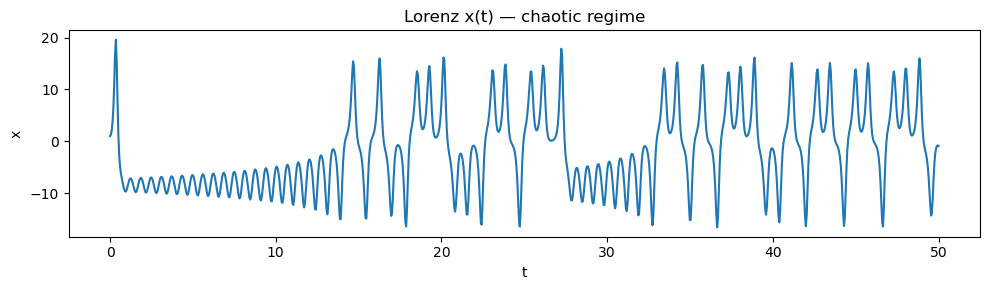

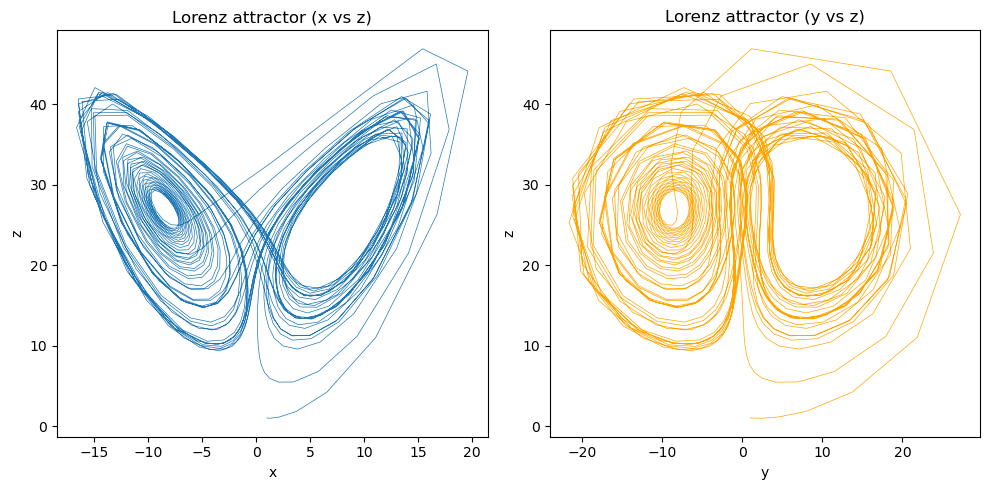

In [3]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

# simulation settings
final_time      = 50.0
# final_time      = 5

num_time_points = 1000
t_span          = (0.0, final_time)
t_eval          = np.linspace(*t_span, num_time_points)

# classic Lorenz parameters (chaotic regime)
sigma, rho, beta = 10.0, 28.0, 8.0/3.0

# one “small” perturbation from the origin
IC = [1.0, 1.0, 1.0]

# solve
sol = solve_ivp(
    fun=lorenz,
    t_span=t_span,
    y0=IC,
    t_eval=t_eval,
    args=(sigma, rho, beta),
    method='RK45',
)

# put results in a DataFrame if you like
data_matrix_df = pd.DataFrame(sol.y.T, columns=['x','y','z'])
data_matrix_df['t'] = sol.t
data_matrix_df_list = [data_matrix_df]

# --- now plot! ---

# 1) the x(t) time series
plt.figure(figsize=(10,3))
plt.plot(sol.t, sol.y[0])
plt.title('Lorenz x(t) — chaotic regime')
plt.xlabel('t')
plt.ylabel('x')
plt.tight_layout()
plt.show()

# 2) the phase‐space portrait x vs z
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left subplot: x vs z
axs[0].plot(sol.y[0], sol.y[2], linewidth=0.5)
axs[0].set_title('Lorenz attractor (x vs z)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')

# Right subplot: y vs z
axs[1].plot(sol.y[1], sol.y[2], linewidth=0.5, color='orange')
axs[1].set_title('Lorenz attractor (y vs z)')
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')

plt.tight_layout()
plt.show()

from copy import deepcopy

data_matrix_df_orig = deepcopy(data_matrix_df_list[0])


<Axes: >

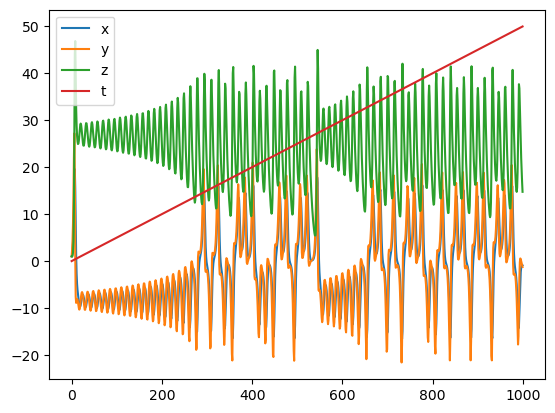

In [4]:
data_matrix_df.plot()

# Main

## Defining Cadidate library (RHS of equations)

noise_magnitude: 0.0
noise_percentage: 0.0
x_true: [  9.4900312    3.88733023   2.2347181   -5.32524335  11.90178603
 -17.6793415   -5.7444432   -7.78986019  -4.77109987  50.78132216
 -78.80829634  16.46948406  51.12202828 -25.9468436  -25.61524743
 -12.40869804   9.37065918  32.07253622  -0.08016794  10.06320807
 -19.12642824 -39.20036901  12.52223239  58.0355347  -18.61131407
  -0.76986324 -34.95423564  20.61098557  23.1651096   -1.50576171
   7.11758346  -5.57241411 -19.02746364   4.39980621]
x_model: [  9.4900312    3.88733023   2.2347181   -5.32524335  11.90178603
 -17.6793415   -5.7444432   -7.78986019  -4.77109987  50.78132216
 -78.80829634  16.46948406  51.12202828 -25.9468436  -25.61524743
 -12.40869804   9.37065918  32.07253622  -0.08016794  10.06320807
 -19.12642824 -39.20036901  12.52223239  58.0355347  -18.61131407
  -0.76986324 -34.95423564  20.61098557  23.1651096   -1.50576171
   7.11758346  -5.57241411 -19.02746364   4.39980621]
x_model-x_true [0. 0. 0. 0. 0. 0. 0. 0. 

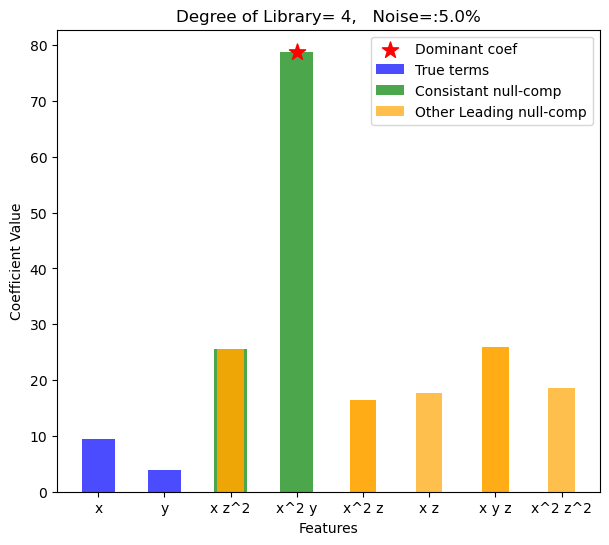

In [5]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from copy import deepcopy
#Adding noise to the data matrix
noise_perc = 0.05

data_matrix_df = deepcopy(data_matrix_df_orig)
for col in data_matrix_df.columns:
    if col != 't':
        data_matrix_df[col] += np.random.normal(0, noise_perc * data_matrix_df[col].std(), size=data_matrix_df[col].shape)
t_exact = data_matrix_df["t"]

#Defining candidate library
from dae_finder import PolyFeatureMatrix

poly_degree = 4

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df.drop("t", axis=1))


#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)

# #scaling the columns
# from sklearn.preprocessing import normalize
# scaled_cand_lib = pd.DataFrame(normalize(candidate_lib_full, norm='l2', axis=0), columns=candidate_lib_full.columns)
# if '1' in scaled_cand_lib.columns:
#         scaled_cand_lib['1'] = 1


#scaling the candidate columns to set std of 1
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib_full), columns=s_scaler.feature_names_in_)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

# scaled_cand_lib = candidate_lib_full

#Converting the scaled candidate library to a numpy array
A = scaled_cand_lib.to_numpy()
a = np.ones((A.shape[0], 1))
A_design = np.hstack((a, A))

U, S, Vt = np.linalg.svd(A_design, full_matrices=True)



dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')
y = dx_dt_series.to_numpy()
# y = dx_dt_svgol_filter

# y_noise_comp = A @ noise_comp
# y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
ill_noise_perc = 0.00
other_noise_perc = 0.00

y_noise_comp = U[:,A_design.shape[1]-1] * np.linalg.norm(y)*ill_noise_perc
# y_noise_comp = (U[:,A_design.shape[1]-1] +U[:,A_design.shape[1]-2]) * np.linalg.norm(y)*ill_noise_perc

y_noisy = y + y_noise_comp + np.random.randn(*y.shape) * np.linalg.norm(y) * other_noise_perc
# from sklearn.linear_model import Ridge
lin_model_true = LinearRegression(fit_intercept=True)
lin_model_true.fit(A, y)
# lin_model = LinearRegression()
lin_model_true.fit(scaled_cand_lib, dx_dt_series)
x = lin_model_true.coef_


lin_model = LinearRegression(fit_intercept=True)
# lin_model = Ridge(alpha=1, fit_intercept=True)
lin_model.fit(scaled_cand_lib, y_noisy)
x_model = lin_model.coef_

print("noise_magnitude:", np.linalg.norm(np.linalg.norm(y_noisy - y)))
print("noise_percentage:", np.linalg.norm(np.linalg.norm(y_noisy - y)/ np.linalg.norm(y)))

print("x_true:", x)
print("x_model:", x_model)
print("x_model-x_true", x_model-(x))
print("relative norm(x - lin_model.coef_)/norm(x):", np.linalg.norm(x - x_model)/ np.linalg.norm(x))

# Create a tuple containing the index and value of each component of Vt[-1, :]
x_model_last = [(index, value) for index, value in enumerate(lin_model.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_model_last = sorted(x_model_last, key=lambda x: abs(x[1]))
sorted_x_model_last = sorted_x_model_last[::-1]
sorted_x_model_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_model_last}
sorted_x_model_df = pd.DataFrame.from_dict(sorted_x_model_dict, orient='index', columns=['Coefficient'])


# Create a tuple containing the index and value of each component of Vt[-1, :]
x_true_last = [(index, value) for index, value in enumerate(lin_model_true.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_true_last = sorted(x_true_last, key=lambda x: abs(x[1]))
sorted_x_true_last = sorted_x_true_last[::-1]
sorted_x_true_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_true_last}
sorted_x_true_df = pd.DataFrame.from_dict(sorted_x_true_dict, orient='index', columns=['Coefficient'])



# Create a tuple containing the index and value of each component of Vt[-1, :]
vt_last_component = [(index, value) for index, value in enumerate(Vt[-1, :][1:])]
# Sort the tuple based on the magnitude of the value
sorted_vt_last_component = sorted(vt_last_component, key=lambda x: abs(x[1]))
sorted_vt_last_component = sorted_vt_last_component[::-1]
sorted_vt_last_component_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component}
sorted_vt_last_component_df = pd.DataFrame.from_dict(sorted_vt_last_component_dict, orient='index', columns=['Coefficient'])

# Create a tuple containing the index and value of each component of Vt[-1, :]
vt_last_component_2 = [(index, value) for index, value in enumerate(Vt[-2, :][1:])]
sorted_vt_last_component_2 = sorted(vt_last_component_2, key=lambda x: abs(x[1]))
sorted_vt_last_component_2 = sorted_vt_last_component_2[::-1]
sorted_vt_last_component_dict_2 = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component_2}
sorted_vt_last_component_df_2 = pd.DataFrame.from_dict(sorted_vt_last_component_dict_2, orient='index', columns=['Coefficient'])




import matplotlib.pyplot as plt


true_model_coef = ["x", "y"]
consistent_null = ["x z^2", "x^2 y"]
true_model_df = sorted_vt_last_component_df.loc[true_model_coef]

# Extract the first four indices of vt_last_component
vt_dom_components = list(sorted_vt_last_component_df.index[:4]) + list(sorted_vt_last_component_df_2.index[:4]) 
dominant_model_coef = sorted_x_model_df.index[:5]
dominant_comp_plot=[]

all_comps = set(true_model_coef+vt_dom_components+consistent_null)
for feature in dominant_model_coef:
     if feature in all_comps:
        dominant_comp_plot.append(feature)
     


# Create a bar plot
fig, ax = plt.subplots(figsize=(7, 6)) 

# Plot the first two indices of sorted_x_model_df with smaller bar thickness

ax.bar(true_model_coef, abs(sorted_x_model_df.loc[true_model_coef]['Coefficient']), label='True terms', color='blue', alpha=0.7, width=0.5)

ax.bar(consistent_null, abs(sorted_x_model_df.loc[consistent_null]['Coefficient']), label='Consistant null-comp', color='green', alpha=0.7, width=0.5)

# Plot the first four indices of vt_last_component with smaller bar thickness
ax.bar(vt_dom_components, abs(sorted_x_model_df.loc[vt_dom_components]['Coefficient']), label='Other Leading null-comp', color='orange', alpha=0.7, width=0.4)

# Plot the first four indices of dominant_model_coef
# ax.bar(dominant_model_coef, abs(sorted_x_model_df.loc[dominant_model_coef]['Coefficient']), label='Dom-fit-comp', color='green', alpha=0.7, width=0.4)

# Add scatter plots for the true model coefficients
# ax.scatter(true_model_coef, abs(sorted_x_true_df.loc[true_model_coef]['Coefficient']), label='True term', color='red', marker='o', s=100)
# ax.scatter(vt_dom_components, abs(sorted_x_true_df.loc[vt_dom_components]['Coefficient']),label='Lead null-comp', color='red', marker='*', s=150)
ax.scatter(dominant_comp_plot, abs(sorted_x_true_df.loc[dominant_comp_plot]['Coefficient']),label='Dominant coef', color='red', marker='*', s=150)


# Add labels and title
ax.set_ylabel('Coefficient Value')
ax.set_xlabel('Features')

ax.set_title('Degree of Library= {},   Noise=:{}'.format(poly_degree, noise_perc*100) + '%')
ax.legend()

plt.show()
# file_name = "OLS_degree_{}_noise_{}.png".format(poly_degree, other_noise_perc*100)
# fig.savefig(os.path.join("figures", file_name), dpi=300)


## Orthogonaliztion and Stabilization

### Finding numerical derivatives and QR decomposition

In [6]:
# Use the scaled_cand_lib to get the columns 'x', 'y', 'z'
# x_vals = scaled_cand_lib['x'].values
# y_vals = scaled_cand_lib['y'].values
# z_vals = scaled_cand_lib['z'].values

x_vals =  candidate_lib_full['x'].values
y_vals = candidate_lib_full['y'].values
z_vals = candidate_lib_full['z'].values

# Lorenz parameters (already defined above)
# sigma, rho, beta = 10.0, 28.0, 8.0/3.0

# Compute dx/dt using the Lorenz function for each row
dx_dt_lorenz = np.array([
    lorenz(0, [x, y, z], sigma, rho, beta)[0]
    for x, y, z in zip(x_vals, y_vals, z_vals)
])
dy_dt_lorenz = np.array([
    lorenz(0, [x, y, z], sigma, rho, beta)[1]
    for x, y, z in zip(x_vals, y_vals, z_vals)
])

dz_dt_lorenz = np.array([
    lorenz(0, [x, y, z], sigma, rho, beta)[2]
    for x, y, z in zip(x_vals, y_vals, z_vals)
])


# Apply a simple moving average smoothing to x_vals before computing the gradient
window_size = 2
x_smooth = np.convolve(x_vals, np.ones(window_size)/window_size, mode='same')
dx_dt_finite_diff = np.gradient(x_smooth, t_exact)

y_smooth = np.convolve(y_vals, np.ones(window_size)/window_size, mode='same')
dy_dt_finite_diff = np.gradient(y_smooth, t_exact)

from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter to smooth x_vals before computing the gradient
window_length = 7  # should be odd and less than the size of x_vals
polyorder = 3
# x_smooth = savgol_filter(x_vals, window_length, polyorder)
dx_dt_svgol_filter = np.gradient(x_smooth, t_exact)

y_smooth = savgol_filter(y_vals, window_length, polyorder)

# dy_dt_svgol_filter = np.gradient(y_smooth, t_exact)
dy_dt_svgol_filter = savgol_filter(y_vals, window_length, polyorder, deriv=1, delta=t_exact[1]-t_exact[0])

z_smooth = savgol_filter(z_vals, window_length, polyorder)
dz_dt_svgol_filter = np.gradient(z_smooth, t_exact)


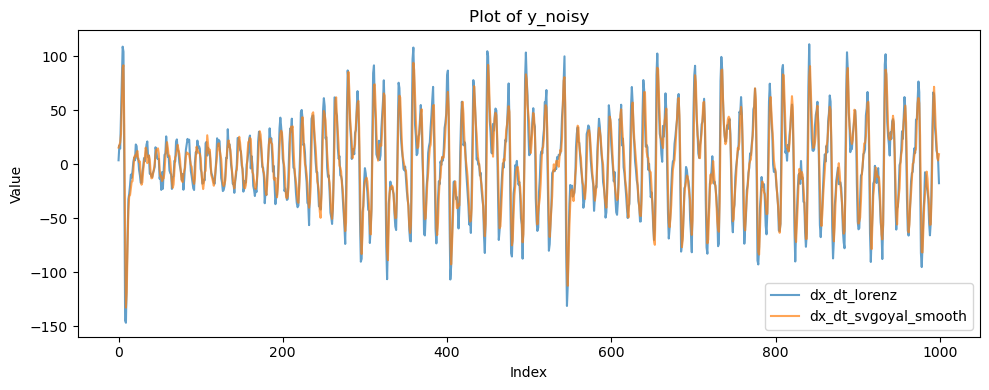

In [7]:
#Checking the accurcy of the derivative estimates

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
# plt.plot(y, label='y_noisy')
plt.plot(dx_dt_lorenz, label='dx_dt_lorenz', alpha=0.7)
# plt.plot(dy_dt_lorenz, label='dy_dt_lorenz', alpha=0.7)

# plt.plot(dy_dt_finite_diff, label='dy_dt_fd_smooth', alpha=0.7)
plt.plot(dx_dt_svgol_filter, label='dx_dt_svgoyal_smooth', alpha=0.7)
# plt.plot(dy_dt_svgol_filter, label='dy_dt_svgoyal_smooth', alpha=0.7)




plt.title('Plot of y_noisy')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

#### Optional rearrangement of columns of candidate library based on the magnitude of projection of the RHS onto the vector

In [8]:
project_and_rearrange = False
b_ = dx_dt_svgol_filter
# b_ = dy_dt_svgol_filter
# b_ = dz_dt_svgol_filter

inner_products = np.abs(scaled_cand_lib.apply(lambda col: np.dot(b_, col)))
sorted_columns = inner_products.sort_values()[::-1].index
if project_and_rearrange:
    scaled_cand_lib = scaled_cand_lib[sorted_columns]
scaled_cand_lib.head()

,x,y,z,x^2,x y,x z,y^2,y z,z^2,x^3,...,x^2 z^2,x y^3,x y^2 z,x y z^2,x z^3,y^4,y^3 z,y^2 z^2,y z^3,z^4
0,0.13266950,0.15887872,0.17460775,0.01583868,0.01861640,0.00611708,0.01869193,0.00865988,0.00499661,0.00089797,...,0.00002359,0.00010166,0.00006073,0.00003593,0.00001004,0.00009407,0.00006411,0.00004492,0.00001739,0.00000606
1,0.19633453,0.37317085,0.05847786,0.03468728,0.06470878,0.00303178,0.10311885,0.00681211,0.00056044,0.00291031,...,0.00000580,0.00194949,0.00016605,0.00001401,0.00000056,0.00286289,0.00027822,0.00002780,0.00000153,0.00000008
2,0.38579607,0.50713429,0.14714512,0.13393451,0.17279835,0.01499041,0.19044457,0.02329440,0.00354846,0.02208119,...,0.00014169,0.00961453,0.00151625,0.00023682,0.00001747,0.00976485,0.00175708,0.00032502,0.00003321,0.00000306
3,0.46285224,0.94400246,0.18737105,0.19277985,0.38589959,0.02290101,0.65988596,0.05521516,0.00575378,0.03813083,...,0.00033069,0.07439833,0.00802627,0.00085758,0.00004327,0.11723740,0.01443110,0.00182609,0.00012765,0.00000804
4,0.82932642,1.63243853,0.44109406,0.61891055,1.19569703,0.09659763,1.97331450,0.22477643,0.03188678,0.21934395,...,0.00588358,0.68934633,0.10124018,0.01472574,0.00101137,1.04838556,0.17567881,0.03026267,0.00287995,0.00024695


In [9]:
inner_products.sort_values()[::-1]

y         20423.11056773
y^3       20173.12628024
x y^2     18412.31366901
y^3 z     17907.22796612
y z       16576.95094722
x^2 y     15483.98026613
x y^2 z   15419.06444496
y z^2     12624.16339289
x^2 y z   12043.32942852
y z^3      9338.15732693
x^3        7130.65422066
x z^3      5754.48191853
x          4799.61621787
x z^2      3850.11039976
x^3 z      3708.11682619
y^2 z      1006.68462611
y^2         899.54184007
y^2 z^2     787.58189808
x y         584.04653311
z^3         525.65188302
x z         515.65008576
z^2         514.84117383
z^4         459.02643394
y^4         441.68667734
x y z       404.33104242
z           335.90136360
x^2         283.26260271
x y^3       249.21752525
x^2 z       121.99054479
x y z^2      99.70580386
x^4          51.55711727
x^2 y^2      47.58597101
x^3 y        32.58845320
x^2 z^2      10.03107105
dtype: float64

In [10]:
A = scaled_cand_lib.to_numpy()
# A = candidate_lib_full.to_numpy()

a = np.ones((A.shape[0], 1))
A_design = np.hstack((a, A))

U, S, Vt = np.linalg.svd(A_design, full_matrices=True)
S

array([1.74616481e+02, 1.16867827e+02, 7.74782171e+01, 4.40475030e+01,
       3.92609431e+01, 2.32608974e+01, 1.84336126e+01, 1.57683839e+01,
       1.43434664e+01, 9.58405646e+00, 6.65362754e+00, 5.71184043e+00,
       4.32204546e+00, 3.59043535e+00, 3.45962322e+00, 3.10569239e+00,
       2.70138984e+00, 2.20055068e+00, 1.40860334e+00, 1.02582455e+00,
       9.02921028e-01, 7.82886685e-01, 6.21294948e-01, 4.76558164e-01,
       4.46848086e-01, 3.87304514e-01, 2.35359262e-01, 1.91756287e-01,
       1.66241571e-01, 1.12059058e-01, 7.32655751e-02, 4.83775964e-02,
       4.38478911e-02, 2.69515620e-02, 2.48412210e-02])

### QR decomposition with pivoting based on Householder reflections

In [11]:
from scipy.linalg import qr
import numpy as np
# from helper_functions import QR_with_threshold

# Compute the pivoted QR decomposition of A_design
Q, R, P = qr(A_design, mode='economic', pivoting=True)
# Q, R = qr(A_design, mode='economic', pivoting=False)
# Q, R, P = qr(A, mode='economic', pivoting=True)

# Q: orthogonal matrix, R: upper triangular matrix, P: pivot indice

# Q, R, P, L = mgs_qr_dependence_pivot(A_design, tol=1e-2, reorth_tail=True)
# Q, R, P, L = QR_with_threshold(A_design, rank_threshold=2e-1, stable_right=True, verbose=False)


In [12]:
print("----Residual norms----")
for i, r_ii in enumerate(np.diag(R)):
    print(f"R[{i},{i}] = {r_ii}")

----Residual norms----
R[0,0] = -99.0886221360124
R[1,1] = -32.037354629034795
R[2,2] = -31.61255243418834
R[3,3] = 26.884015497196806
R[4,4] = 25.08591260331606
R[5,5] = -17.24339814145481
R[6,6] = -12.697766340486883
R[7,7] = -11.103731004036312
R[8,8] = 11.06146748988294
R[9,9] = -7.727996044685798
R[10,10] = -5.778121063440001
R[11,11] = 4.541795721005514
R[12,12] = -4.181622099215551
R[13,13] = 3.8620044823690636
R[14,14] = -3.493174065665862
R[15,15] = 3.438005227191889
R[16,16] = -3.0831408186980402
R[17,17] = 2.193892661696236
R[18,18] = -1.5437478026335498
R[19,19] = -1.0806263062955952
R[20,20] = 0.9282706818792389
R[21,21] = -0.8060706030323479
R[22,22] = 0.7056979406580675
R[23,23] = 0.5985333426298683
R[24,24] = 0.5447598471088949
R[25,25] = -0.39650437084323076
R[26,26] = 0.37736565724290316
R[27,27] = 0.2773640035822982
R[28,28] = 0.2241602869111812
R[29,29] = -0.17233465017040242
R[30,30] = -0.11480830720340016
R[31,31] = 0.09300355605891568
R[32,32] = -0.07631560847528

In [13]:
print("--- Pivotted column index after QR based on Householder reflection ---")
col = candidate_lib_full.columns
col = np.array(['1'] + list(col))
col[P]

for ind, col_ in enumerate(col[P]):
    print("{}: {}".format(ind,col_))

--- Pivotted column index after QR based on Householder reflection ---
0: z
1: y^2
2: y^3 z
3: x z^3
4: x^2 z^2
5: y
6: y^4
7: y^2 z^2
8: y z^3
9: z^3
10: x
11: x^2
12: y^3
13: 1
14: x^2 y z
15: x^3 y
16: x y z^2
17: x^3
18: y z
19: x^3 z
20: y^2 z
21: x^4
22: x y
23: x y^3
24: x y^2 z
25: x z
26: z^4
27: x^2 y
28: x^2 z
29: y z^2
30: z^2
31: x^2 y^2
32: x y^2
33: x y z
34: x z^2


### Finding model based on independent columns and QR structure. 

In [14]:
# Number of independendent columns
L_ind = 15
print(" Independent columns: ", col[P][:L_ind])
# print(list(zip(candidate_lib_full.columns[P][:L_ind], np.diag(R)[:L_ind])))
col = candidate_lib_full.columns
col = np.array(['1'] + list(col))
# b = y_noisy
# b = dx_dt_lorenz
# b = dy_dt_lorenz
# b = dx_dt_finite_diff
# b = dx_dt_svgol_filter
b = b_

b_proj_rel_res_list = []

b_proj = np.zeros(b.shape)
b_proj_exteneded = np.zeros(b.shape)
b_proj_cord_list = []
for i in range(L_ind):
    print("iteration: ", i)
    b_proj_cord = Q[:, i].T @ b
    b_proj_cord_list.append(b_proj_cord)
    # b_proj += b_proj_cord * Q[:, i]
    b_proj += b_proj_cord * Q[:, i]
    b_proj_exteneded += b_proj_cord * Q[:, i]
    b_proj_rel_res = np.linalg.norm(b - b_proj)/np.linalg.norm(b)
    b_proj_rel_res_list.append(b_proj_rel_res)
    print("R value for feature {}: {}".format(col[P][i], R[i,i]))
    print("Residual norm: {}".format(b_proj_rel_res))

for i in range(L_ind,Q.shape[1]):
    b_proj_cord = Q[:, i].T @ b
    b_proj_exteneded += b_proj_cord * Q[:, i]
    b_proj_rel_res = np.linalg.norm(b - b_proj_exteneded)/np.linalg.norm(b)
    b_proj_rel_res_list.append(b_proj_rel_res)
    # print("R value for feature {}: {}".format(col[P][i], R[i,i]))
    # print("Residual norm: {}".format(b_proj_rel_res))

model_dict_proj = dict(zip(col[P[:L_ind]], np.linalg.solve(R[:L_ind, :L_ind], b_proj_cord_list)))
model_proj_thresh =  stols(model_dict_proj, pd_dict=True, threshold=10)
model_proj_thresh

 Independent columns:  ['z' 'y^2' 'y^3 z' 'x z^3' 'x^2 z^2' 'y' 'y^4' 'y^2 z^2' 'y z^3' 'z^3' 'x'
 'x^2' 'y^3' '1' 'x^2 y z']
iteration:  0
R value for feature z: -99.0886221360124
Residual norm: 0.9999958284574092
iteration:  1
R value for feature y^2: -32.037354629034795
Residual norm: 0.9996552861731135
iteration:  2
R value for feature y^3 z: -31.61255243418834
Residual norm: 0.8750626397183336
iteration:  3
R value for feature x z^3: 26.884015497196806
Residual norm: 0.7322682866658824
iteration:  4
R value for feature x^2 z^2: 25.08591260331606
Residual norm: 0.732164920588561
iteration:  5
R value for feature y: -17.24339814145481
Residual norm: 0.5925425802599776
iteration:  6
R value for feature y^4: -12.697766340486883
Residual norm: 0.5914403403573879
iteration:  7
R value for feature y^2 z^2: -11.103731004036312
Residual norm: 0.5912726501421225
iteration:  8
R value for feature y z^3: 11.06146748988294
Residual norm: 0.5110226420162868
iteration:  9
R value for feature z^3

,Coefficient
x z^3,17.92486417
y,92.02554381
x,-89.97220179


In [15]:
selected_features = stols(model_proj_thresh.to_dict()['Coefficient'], pd_dict=True, threshold=10).index
if '1' in selected_features:
    fit_intercept = True
    selected_features = [f for f in selected_features if f != '1']
else:
    fit_intercept = False
X_selected = scaled_cand_lib[selected_features]
# selected_features = col[P][1:L_ind]

# X_selected = scaled_cand_lib[selected_features]
    
# X_selected = candidate_lib_full[selected_features]

from sklearn.linear_model import Lasso
# Fit Lasso regression
lasso = Lasso(alpha=0.3, fit_intercept=fit_intercept, max_iter=10000)
model_ = lasso
# model_ = Ridge(alpha=0.3)
model_.fit(X_selected, b_)

# Print the coefficients as a DataFrame

model_coef_df = pd.DataFrame({'Coefficient': model_.coef_}, index=selected_features)
print(model_coef_df)

       Coefficient
x z^3  12.06790988
y      81.76877221
x     -77.57406825


In [16]:
from dae_finder import sequentialThLin
seq_model = sequentialThLin(coef_threshold=2,alpha=0.3, fit_intercept=False, model_id='lasso')
# custom_model_arg  = {alpha:0.01, fit_intercept:True, max_iter:10000}
# seq_model = sequentialThLin(custom_model=True, custom_model_ob=model_,custom_model_arg=custom_model_arg, coef_threshold=1)

seq_model.fit(X_selected, b_)
seq_model.coef_history_df

Sequential threshold converged in 0 iterations


,x z^3,y,x
0,12.06790988,81.76877221,-77.57406825


### Assembling matrix to represent algebraic relationships and null space basis

In [17]:
#Assembling C matrix to represent family of solutions: see Lemma 1 in manuscript 

R_1 = R[:L_ind, :L_ind]
R_2 = R[:L_ind:, L_ind:]

C_1 = np.hstack([np.array(b_proj_cord_list), np.zeros(R.shape[1]-L_ind)])

C_0 = np.linalg.solve(R_1, R_2)
C_2 = np.vstack([C_0, np.eye(C_0.shape[1])])

R_1.shape, R_2.shape, C_1.shape,  C_0.shape, C_2.shape

((15, 15), (15, 20), (35,), (15, 20), (35, 20))

In [18]:
relation_df = pd.DataFrame(C_0, index=col[P][:L_ind], columns=col[P][L_ind:])

threshold = 0.15
relation_df_filtered = relation_df.applymap(lambda x: x if abs(x) >= threshold else 0)

relation_df_filtered

/var/folders/1h/sr7kc8_d5pddvym2zw5gv28r0000gn/T/ipykernel_41096/699553697.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  relation_df_filtered = relation_df.applymap(lambda x: x if abs(x) >= threshold else 0)


,x^3 y,x y z^2,x^3,y z,x^3 z,y^2 z,x^4,x y,x y^3,x y^2 z,x z,z^4,x^2 y,x^2 z,y z^2,z^2,x^2 y^2,x y^2,x y z,x z^2
z,0.00000000,0.19124933,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.16943747,0.00000000,0.00000000,0.00000000,-0.18130183,0.00000000,0.00000000,0.00000000,0.36017568,0.00000000,0.00000000,0.22029217,0.00000000
y^2,-0.25986057,-0.17212276,0.00000000,0.00000000,0.00000000,0.33591157,0.00000000,0.41280279,-0.16677136,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.25457498,0.00000000,0.00000000,0.00000000
y^3 z,0.00000000,-0.16310069,-0.27078366,0.42217159,-0.25225186,0.00000000,0.00000000,0.00000000,0.00000000,0.63097607,0.21368365,0.00000000,-0.17470267,0.00000000,0.33923311,0.00000000,0.00000000,0.00000000,0.00000000,0.15016222
x z^3,0.00000000,0.00000000,0.48822202,0.00000000,0.78075594,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.26274991,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.62520017
x^2 z^2,0.38576731,0.59561345,0.00000000,0.00000000,0.00000000,0.00000000,1.09983249,0.00000000,0.00000000,0.00000000,0.00000000,0.35733117,0.00000000,0.46218262,0.00000000,-0.17515065,0.00000000,0.00000000,0.23155346,0.00000000
y,0.00000000,0.00000000,0.00000000,0.40999854,0.25494140,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.25854699,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.20287733
y^4,0.36866406,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.20948621,0.00000000,0.83981929,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.61205802,0.00000000,0.00000000,0.00000000
y^2 z^2,0.67674786,0.67648131,0.00000000,0.00000000,0.00000000,0.61286192,0.27805094,0.00000000,0.32897875,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.61578205,0.00000000,0.53160625,0.00000000
y z^3,0.18658267,0.00000000,0.00000000,0.72399842,-0.25322949,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.25527700,0.00000000,0.00000000,0.00000000,1.00474613,0.00000000,0.00000000,0.00000000,0.00000000,0.19479181
z^3,-0.26379823,-0.50694249,0.00000000,0.00000000,0.00000000,0.00000000,-0.33966495,-0.45662130,0.00000000,0.00000000,0.00000000,1.07650304,0.00000000,0.00000000,0.00000000,0.69308961,0.00000000,0.00000000,-0.53318757,0.00000000


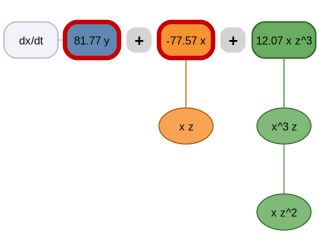

In [ ]:
threshold = 1
redundancy_thresh = 0.5

draw_relation_map(model_coef_df, relation_df_filtered.T, column_name = "Coefficient",eq_lhs_label='dx/dt',
                   true_terms=['x', 'y'], model_threshold=threshold, redundancy_threshold=redundancy_thresh)

# mains = model_coef_df.index[model_coef_df['Coefficient'].abs() > threshold]
# mains = mains[np.argsort(model_coef_df.loc[mains, 'Coefficient'].abs())].tolist()[::-1]
# main_values = [f"{v:.2f}" for v in model_coef_df.loc[mains, 'Coefficient']]
# children_df = relation_df_filtered.T
# children = {col: children_df.index[children_df[col] > 0.0001].tolist() for col in children_df.columns}
# draw_lr_mains_with_vertical_children(mains, children, main_values=main_values, left_label="dx/dt", notebook_format="svg")



## Plots

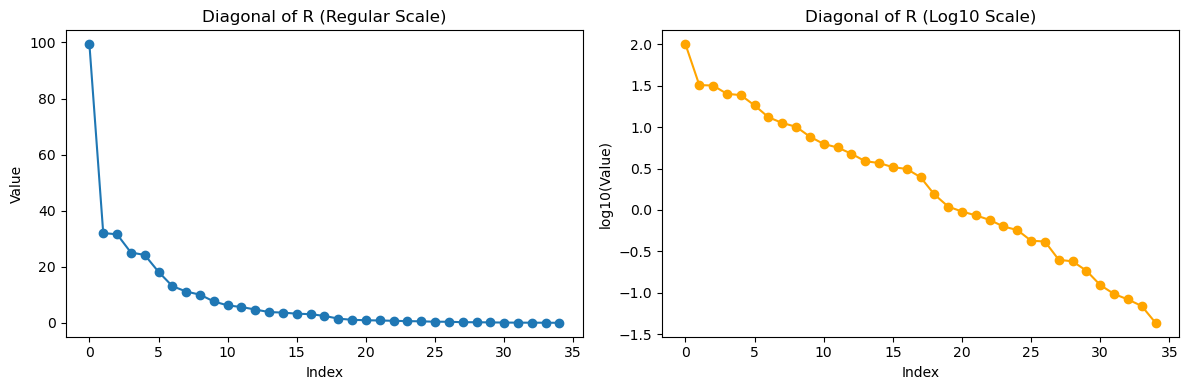

In [ ]:
import matplotlib.pyplot as plt

diag_R = np.abs(np.diag(R))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Regular scale
axs[0].plot(diag_R, marker='o')
axs[0].set_title('Diagonal of R (Regular Scale)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Log scalewhate
axs[1].plot(np.log10(np.abs(diag_R)), marker='o', color='orange')
axs[1].set_title('Diagonal of R (Log10 Scale)')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('log10(Value)')

plt.tight_layout()
plt.show()

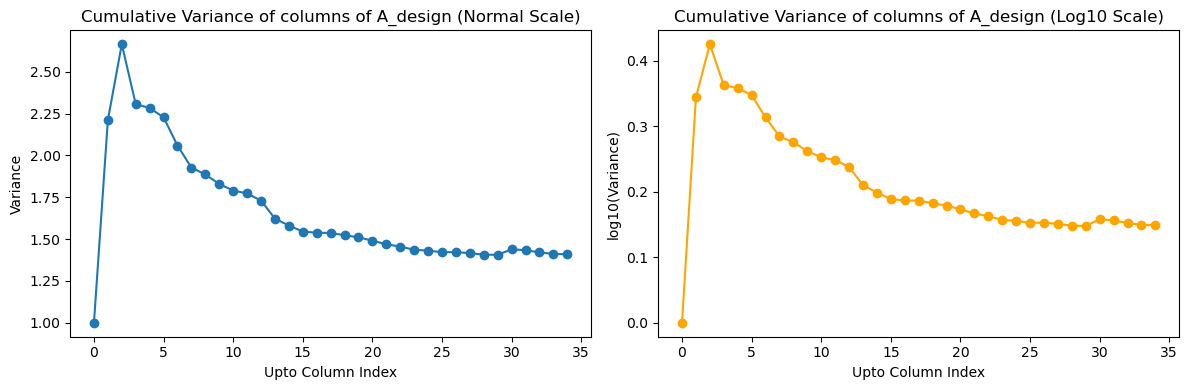

In [ ]:
A_var_column_ratio_list = [A_design[:, P][:,0:i+1].var() for i in range(A_design.shape[1])]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Regular scale
axs[0].plot(A_var_column_ratio_list, marker='o')
axs[0].set_title('Cumulative Variance of columns of A_design (Normal Scale)')
axs[0].set_xlabel('Upto Column Index')
axs[0].set_ylabel('Variance')

# Log scale
axs[1].plot(np.log10(np.abs(A_var_column_ratio_list)), marker='o', color='orange')
axs[1].set_title('Cumulative Variance of columns of A_design (Log10 Scale)')
axs[1].set_xlabel('Upto Column Index')
axs[1].set_ylabel('log10(Variance)')

plt.tight_layout()
plt.show()

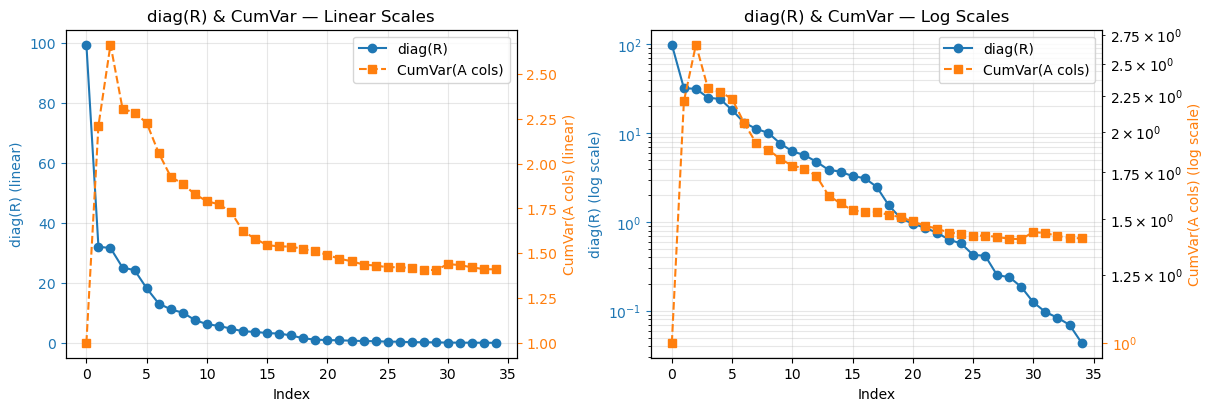

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data (your originals)
diag_R = np.abs(np.diag(R))
A_var_column_ratio_list = [A_design[:, P][:, :i+1].var() for i in range(A_design.shape[1])]

# X indices (can differ)
x_R = np.arange(len(diag_R))
x_A = np.arange(len(A_var_column_ratio_list))

tiny = np.finfo(float).tiny  # to avoid log(0)

# Define fixed colors
color_diagR = "#1f77b4"   # deep blue
color_cumVar = "#ff7f0e"  # bright orange

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# ==========================
# LEFT: linear scales
# ==========================
axL = axes[0]
axL_right = axL.twinx()

# diag(R) — left axis
l1, = axL.plot(x_R, diag_R, marker='o', linestyle='-', color=color_diagR, label='diag(R)')
axL.set_xlabel('Index')
axL.set_ylabel('diag(R) (linear)', color=color_diagR)
axL.tick_params(axis='y', colors=color_diagR)
axL.set_title('diag(R) & CumVar — Linear Scales')
axL.grid(True, alpha=0.3)

# CumVar — right axis
l2, = axL_right.plot(x_A, A_var_column_ratio_list, marker='s', linestyle='--',
                     color=color_cumVar, label='CumVar(A cols)')
axL_right.set_ylabel('CumVar(A cols) (linear)', color=color_cumVar)
axL_right.tick_params(axis='y', colors=color_cumVar)

# Combined legend
lines_L = [l1, l2]
labels_L = [ln.get_label() for ln in lines_L]
axL.legend(lines_L, labels_L, loc='best')

# ==========================
# RIGHT: log scales
# ==========================
axR = axes[1]
axR_right = axR.twinx()

# Apply log scales
axR.set_yscale('log')
axR_right.set_yscale('log')

# diag(R) — left axis
l3, = axR.plot(x_R, np.clip(diag_R, tiny, None), marker='o', linestyle='-', 
               color=color_diagR, label='diag(R)')
axR.set_xlabel('Index')
axR.set_ylabel('diag(R) (log scale)', color=color_diagR)
axR.tick_params(axis='y', colors=color_diagR)
axR.set_title('diag(R) & CumVar — Log Scales')
axR.grid(True, which='both', alpha=0.3)

# CumVar — right axis
l4, = axR_right.plot(x_A, np.clip(A_var_column_ratio_list, tiny, None),
                     marker='s', linestyle='--', color=color_cumVar, label='CumVar(A cols)')
axR_right.set_ylabel('CumVar(A cols) (log scale)', color=color_cumVar)
axR_right.tick_params(axis='y', colors=color_cumVar)

# Combined legend
lines_R = [l3, l4]
labels_R = [ln.get_label() for ln in lines_R]
axR.legend(lines_R, labels_R, loc='best')

plt.show()


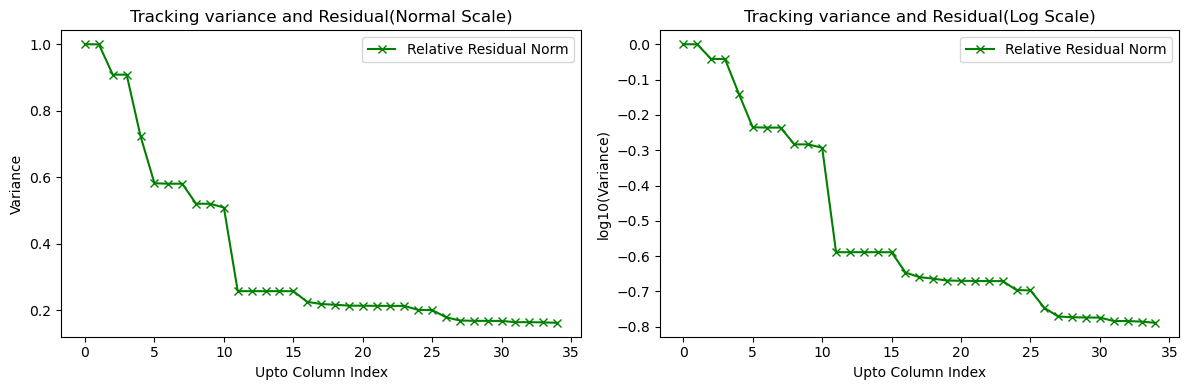

In [ ]:
A_var_column_ratio_list = [A_design[:, P][:,0:i+1].var() for i in range(A_design.shape[1])]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Regular scale
# axs[0].plot(A_var_column_ratio_list, marker='o', label='Cumulative Variance')
axs[0].plot(b_proj_rel_res_list, marker='x', color='green', label='Relative Residual Norm')
axs[0].legend()

axs[0].set_title('Tracking variance and Residual(Normal Scale)')
axs[0].set_xlabel('Upto Column Index')
axs[0].set_ylabel('Variance')

# Log scale
# axs[1].plot(np.log10(np.abs(A_var_column_ratio_list)), marker='o', color='orange', label='Cumulative Variance')
axs[1].plot(np.log10(np.abs(b_proj_rel_res_list)), marker='x', color='green', label='Relative Residual Norm')
axs[1].legend()
axs[1].set_title('Tracking variance and Residual(Log Scale)')
axs[1].set_xlabel('Upto Column Index')
axs[1].set_ylabel('log10(Variance)')

plt.tight_layout()
plt.show()

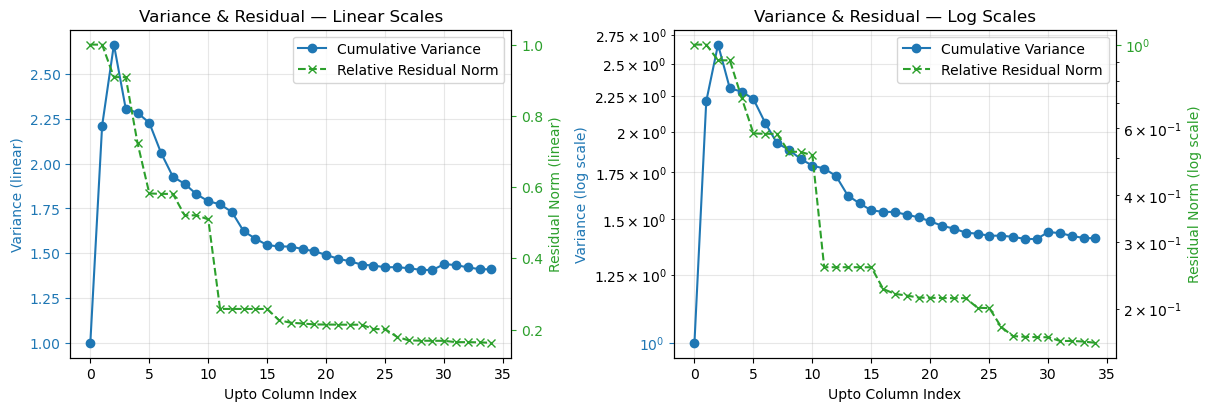

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
A_var_column_ratio_list = [A_design[:, P][:, :i+1].var() for i in range(A_design.shape[1])]
x_A = np.arange(len(A_var_column_ratio_list))
x_RR = np.arange(len(b_proj_rel_res_list))

tiny = np.finfo(float).tiny  # avoid log(0)

# Colors (hex)
color_var = "#1f77b4"   # deep blue
color_res = "#2ca02c"   # green

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# ==========================
# LEFT: linear scales, dual y-axes
# ==========================
axL = axes[0]
axL_r = axL.twinx()

# Cumulative Variance — left y-axis
l1, = axL.plot(x_A, A_var_column_ratio_list, marker='o', linestyle='-',
               color=color_var, label='Cumulative Variance')
axL.set_xlabel('Upto Column Index')
axL.set_ylabel('Variance (linear)', color=color_var)
axL.tick_params(axis='y', colors=color_var)
axL.set_title('Variance & Residual — Linear Scales')
axL.grid(True, alpha=0.3)

# Relative Residual Norm — right y-axis
l2, = axL_r.plot(x_RR, b_proj_rel_res_list, marker='x', linestyle='--',
                 color=color_res, label='Relative Residual Norm')
axL_r.set_ylabel('Residual Norm (linear)', color=color_res)
axL_r.tick_params(axis='y', colors=color_res)

# Legend (combined)
lines_L = [l1, l2]
labels_L = [ln.get_label() for ln in lines_L]
axL.legend(lines_L, labels_L, loc='best')

# ==========================
# RIGHT: log scales, dual y-axes
# ==========================
axR = axes[1]
axR_r = axR.twinx()
axR.set_yscale('log')
axR_r.set_yscale('log')

# Cumulative Variance — left y-axis (log)
l3, = axR.plot(x_A, np.clip(A_var_column_ratio_list, tiny, None),
               marker='o', linestyle='-', color=color_var, label='Cumulative Variance')
axR.set_xlabel('Upto Column Index')
axR.set_ylabel('Variance (log scale)', color=color_var)
axR.tick_params(axis='y', colors=color_var)
axR.set_title('Variance & Residual — Log Scales')
axR.grid(True, which='both', alpha=0.3)

# Relative Residual Norm — right y-axis (log)
l4, = axR_r.plot(x_RR, np.clip(b_proj_rel_res_list, tiny, None),
                 marker='x', linestyle='--', color=color_res, label='Relative Residual Norm')
axR_r.set_ylabel('Residual Norm (log scale)', color=color_res)
axR_r.tick_params(axis='y', colors=color_res)

# Legend (combined)
lines_R = [l3, l4]
labels_R = [ln.get_label() for ln in lines_R]
axR.legend(lines_R, labels_R, loc='best')

plt.show()


## Constrained optimization to find sparse solution with bias towards true model terms

In [ ]:
from scipy.optimize import minimize, LinearConstraint, Bounds
import numpy as np
index_xz = list(col[P]).index('x z')
index_y = list(col[P]).index('y')



# alpha is a vector of length R.shape[1] - L_ind
alpha_dim = R.shape[1] - L_ind

def cost(alpha, penalty=1e-3):
    b_new = (C_1 + C_2 @ alpha).flatten()
    return penalty*np.sum(np.abs(b_new))  # l1 norm

def eq_constraint(alpha):
    b_new = (C_1 + C_2 @ alpha).flatten()
    # return [b_new[9], b_new[10]]
    return [b_new[0]]


def ineq_constraint(alpha):
    b_new = (C_1 + C_2 @ alpha).flatten()
    # return [b_new[27] - 3, b_new[29] - 3]
    return [-b_new[index_xz] - 1]
    # return [b_new[index_y] - 0.1]
    # return []



constraints = [
    {'type': 'eq', 'fun': eq_constraint},
    {'type': 'ineq', 'fun': ineq_constraint}
]

# Optionally, you can add bounds for alpha if needed
bounds = Bounds([-np.inf]*alpha_dim, [np.inf]*alpha_dim)

# Initial guess
alpha0 = np.zeros(alpha_dim)

# result = minimize(cost, alpha0, constraints=constraints, bounds=bounds, method='SLSQP')
result = minimize(cost, alpha0, constraints=constraints, bounds=bounds, method='SLSQP')


print("Optimal alpha:", result.x)
print("Optimal cost:", result.fun)
print("b_new:", (C_1 + C_2 @ result.x).flatten())

Optimal alpha: [ 2.11650778  2.90468141 -0.65185994  0.16736177  0.56956004  0.04534119
  0.15684276  1.69995467  0.83792003 -0.03071304 -0.34576379  3.12488105
  3.25190227  4.2290452   1.45010182  0.2190092   2.5664652 ]
Optimal cost: 0.5064888242995416
b_new: [-9.76905223e-11  8.24917861e-02  1.38963832e+02  4.72549332e-01
 -1.02268920e+02  3.77494759e+01  1.08599422e+01 -3.55025382e-01
  7.86980944e+01 -6.39687251e-01 -2.50699225e+01 -1.21466654e+01
 -1.82566496e+00 -1.50088752e-01 -9.74672918e+00  2.57794385e-03
 -2.93442911e+01 -3.37449555e+01  2.11650778e+00  2.90468141e+00
 -6.51859945e-01  1.67361773e-01  5.69560039e-01  4.53411932e-02
  1.56842761e-01  1.69995467e+00  8.37920033e-01 -3.07130367e-02
 -3.45763789e-01  3.12488105e+00  3.25190227e+00  4.22904520e+00
  1.45010182e+00  2.19009204e-01  2.56646520e+00]


In [ ]:
stols(dict(zip(col[P], (C_1 + C_2 @ result.x).flatten())), pd_dict=True, threshold=1)

,Coefficient
z,138.96383151
x z^2,-102.26892003
z^2,37.74947591
x^2 y^2,10.85994218
z^4,78.69809439
x z,-25.06992248
x^2 y,-12.14666544
x y^3,-1.82566496
x y z^2,-9.74672918
x,-29.34429114


In [ ]:
np.linalg.norm(A_design[:,P] @ (C_1 + C_2 @ result.x) - dy_dt_svgol_filter)

np.float64(3845.700168520103)

In [ ]:
np.linalg.norm(A_design[:,P] @ C_1 - dy_dt_svgol_filter)

np.float64(3963.1590708224508)

In [ ]:
import cvxpy as cp
import numpy as np
import ecos

n = C_1.shape[0]
k = C_2.shape[1]

alpha = cp.Variable(k)
t = cp.Variable(n, nonneg=True)

b = C_1 + C_2 @ alpha

constraints = [
    -t <= b, b <= t,                # t >= |b|
    b >= -20, b <= 20,            # bounds on b
    # b[0] >= -0.000000001, b[0] <= 0.000000001,                      # equality
    b[index_xz] <= -1                   # inequality
]

obj = cp.Minimize(cp.sum(t))  # pure L1 norm of b

prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.CLARABEL)    # or OSQP/CLARABEL/GLPK as available
# prob.solve(solver=ecos)    # or OSQP/CLARABEL/GLPK as available


print("status:", prob.status)
print("opt cost:", prob.value)
print("alpha*:", alpha.value)
print("b*:", b.value)


status: infeasible
opt cost: inf
alpha*: None
b*: None


In [ ]:
import cvxpy as cp
import numpy as np

k = C_2.shape[1]
alpha = cp.Variable(k)
b = C_1 + C_2 @ alpha

delta = 1e-3  # small -> closer to L1, larger -> smoother
constraints = [b >= -15, b <= 15, b[index_xz] <= -10]
obj = cp.Minimize(cp.sum(cp.huber(b, M=delta)))  # convex, smooth

prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.OSQP)  # QP-friendly solver


inf

In [ ]:
lin_model.fit(scaled_cand_lib[["x", "y", "x z"]], dy_dt_svgol_filter)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Expression(AFFINE, UNKNOWN, (35,))

In [ ]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge

# Select the columns from scaled_cand_lib corresponding to model_proj_thresh
# selected_features = list(model_proj_thresh.index)
selected_features = stols(dict(zip(col[P], (C_1 + C_2 @ result.x).flatten())), pd_dict=True, threshold=1).index
# selected_features = col[P][1:L_ind]
X_selected = scaled_cand_lib[selected_features]
# X_selected = candidate_lib_full[selected_features]


# Fit Lasso regression
lasso = Lasso(alpha=0.01, fit_intercept=False, max_iter=10000)
model_ = lasso
# model_ = Ridge(alpha=0.3)
model_.fit(X_selected, b_)

# Print the coefficients as a DataFrame
model_coef_df = pd.DataFrame({'Coefficient': model_.coef_}, index=selected_features)
print(model_coef_df)

         Coefficient
z        -0.01635859
x z^2    -2.73302844
z^2      -0.00000000
x^2 y^2  -0.00000000
z^4       0.01951877
x z     -15.76674367
x^2 y     2.19476046
x y^3    -0.01139118
x y z^2   0.08763380
x        14.19864650
x^2 z    -0.00000000
x y^2    -2.98540034
y z^2     0.00000000
x y      -0.00000000
y z      -2.18759239
x^2 z^2   0.00000000
x^3 y    -0.00000000
x y z    -0.00000000
y         4.17273325


/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.290e+01, tolerance: 4.284e+00
  model = cd_fast.enet_coordinate_descent(


In [ ]:
selected_features = stols(model_coef_df.to_dict()['Coefficient'], pd_dict=True, threshold=1).index
# selected_features = col[P][1:L_ind]
X_selected = scaled_cand_lib[selected_features]
# X_selected = candidate_lib_full[selected_features]


# Fit Lasso regression
lasso = Lasso(alpha=0.01, fit_intercept=False, max_iter=10000)
model_ = lasso
# model_ = Ridge(alpha=0.3)
model_.fit(X_selected, b_)

# Print the coefficients as a DataFrame
model_coef_df = pd.DataFrame({'Coefficient': model_.coef_}, index=selected_features)
print(model_coef_df)

       Coefficient
x z^2  -2.15813144
x z   -16.91767234
x^2 y   2.03591481
x      14.82130819
x y^2  -2.84747820
y z    -1.91132286
y       3.87878057


/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.226e+01, tolerance: 4.284e+00
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from dae_finder import sequentialThLin
seq_model = sequentialThLin(coef_threshold=1,alpha=0.01, fit_intercept=False, model_id='lasso')
# custom_model_arg  = {alpha:0.01, fit_intercept:True, max_iter:10000}
# seq_model = sequentialThLin(custom_model=True, custom_model_ob=model_,custom_model_arg=custom_model_arg, coef_threshold=1)

seq_model.fit(X_selected, b_)
seq_model.coef_history_df

Sequential threshold converged in 1 iterations


/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.009e+02, tolerance: 4.284e+00
  model = cd_fast.enet_coordinate_descent(
/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+02, tolerance: 4.284e+00
  model = cd_fast.enet_coordinate_descent(


,z,x z^2,z^2,x^2 y^2,z^4,x z,x^2 y,x y^3,x y z^2,x,x^2 z,x y^2,y z^2,x y,y z,x^2 z^2,x^3 y,x y z,y
0,0.00000000,-9.51787711,0.00000000,0.00000000,0.00000000,-1.61624119,4.40405840,0.00000000,0.00000000,6.16254139,0.00000000,-4.69124772,0.00000000,0.00000000,-6.49187382,0.00000000,0.00000000,0.00000000,8.34186260
1,NaN,-9.29781206,NaN,NaN,NaN,-1.86729183,4.42727421,NaN,NaN,6.19141155,NaN,-4.70622510,NaN,NaN,-6.15772782,NaN,NaN,NaN,8.24886394


## Making animation for different noise realizations

In [ ]:
import os


# epsilon = 1e-2
# A = np.random.randn(num_data, 4)
# A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(num_data, 1) * epsilon))
# A = scaled_cand_lib.to_numpy()


# y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc
# corr_dir = np.zeros(A.shape[1])
# corr_dir[z_squared_index] = 1
# corr_dir[z_cubed_index] = coefficient_corr



# x = np.random.randn(5)
# x[-2:] *= 0.01
# y = A @ x
#Calculating the derivative of x using finite differences
frame_files = []
for ind in range(50):

    noise_perc = 0.05

    data_matrix_df = deepcopy(data_matrix_df_orig)
    for col in data_matrix_df.columns:
        if col != 't':
            data_matrix_df[col] += np.random.normal(0, noise_perc * data_matrix_df[col].std(), size=data_matrix_df[col].shape)
    t_exact = data_matrix_df["t"]

    #Defining candidate library
    from dae_finder import PolyFeatureMatrix

    poly_degree = 3

    poly_feature_ob = PolyFeatureMatrix(poly_degree)

    candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df.drop("t", axis=1))


    #Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
    # in the candidate library
    candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)

    #scaling the columns
    from sklearn.preprocessing import normalize
    scaled_cand_lib = pd.DataFrame(normalize(candidate_lib_full, norm='l2', axis=0), columns=candidate_lib_full.columns)
    if '1' in scaled_cand_lib.columns:
            scaled_cand_lib['1'] = 1

    #Converting the scaled candidate library to a numpy array
    A = scaled_cand_lib.to_numpy()
    a = np.ones((A.shape[0], 1))
    A_design = np.hstack((a, A))

    U, S, Vt = np.linalg.svd(A_design, full_matrices=True)



    dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)
    dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')
    y = dx_dt_series.to_numpy()

    # y_noise_comp = A @ noise_comp
    # y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
    ill_noise_perc = 0.00
    other_noise_perc = 0.00

    y_noise_comp = U[:,A_design.shape[1]-1] * np.linalg.norm(y)*ill_noise_perc
    # y_noise_comp = (U[:,A_design.shape[1]-1] +U[:,A_design.shape[1]-2]) * np.linalg.norm(y)*ill_noise_perc

    y_noisy = y + y_noise_comp + np.random.randn(*y.shape) * np.linalg.norm(y) * other_noise_perc
    # from sklearn.linear_model import Ridge
    lin_model_true = LinearRegression(fit_intercept=True)
    lin_model_true.fit(A, y)
    # lin_model = LinearRegression()
    lin_model_true.fit(scaled_cand_lib, dx_dt_series)
    x = lin_model_true.coef_


    lin_model = LinearRegression(fit_intercept=True)
    # lin_model = Ridge(alpha=1, fit_intercept=True)
    lin_model.fit(scaled_cand_lib, y_noisy)
    x_model = lin_model.coef_

    # print("noise_magnitude:", np.linalg.norm(np.linalg.norm(y_noisy - y)))
    # print("noise_percentage:", np.linalg.norm(np.linalg.norm(y_noisy - y)/ np.linalg.norm(y)))

    # print("x_true:", x)
    # print("x_model:", x_model)
    # print("x_model-x_true", x_model-(x))
    # print("relative norm(x - lin_model.coef_)/norm(x):", np.linalg.norm(x - x_model)/ np.linalg.norm(x))

    # Create a tuple containing the index and value of each component of Vt[-1, :]
    x_model_last = [(index, value) for index, value in enumerate(lin_model.coef_)]

    # Sort the tuple based on the magnitude of the value
    sorted_x_model_last = sorted(x_model_last, key=lambda x: abs(x[1]))
    sorted_x_model_last = sorted_x_model_last[::-1]
    sorted_x_model_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_model_last}
    sorted_x_model_df = pd.DataFrame.from_dict(sorted_x_model_dict, orient='index', columns=['Coefficient'])


    # Create a tuple containing the index and value of each component of Vt[-1, :]
    x_true_last = [(index, value) for index, value in enumerate(lin_model_true.coef_)]

    # Sort the tuple based on the magnitude of the value
    sorted_x_true_last = sorted(x_true_last, key=lambda x: abs(x[1]))
    sorted_x_true_last = sorted_x_true_last[::-1]
    sorted_x_true_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_true_last}
    sorted_x_true_df = pd.DataFrame.from_dict(sorted_x_true_dict, orient='index', columns=['Coefficient'])



    # Create a tuple containing the index and value of each component of Vt[-1, :]
    vt_last_component = [(index, value) for index, value in enumerate(Vt[-1, :][1:])]
    # Sort the tuple based on the magnitude of the value
    sorted_vt_last_component = sorted(vt_last_component, key=lambda x: abs(x[1]))
    sorted_vt_last_component = sorted_vt_last_component[::-1]
    sorted_vt_last_component_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component}
    sorted_vt_last_component_df = pd.DataFrame.from_dict(sorted_vt_last_component_dict, orient='index', columns=['Coefficient'])

    # Create a tuple containing the index and value of each component of Vt[-1, :]
    vt_last_component_2 = [(index, value) for index, value in enumerate(Vt[-2, :][1:])]
    sorted_vt_last_component_2 = sorted(vt_last_component_2, key=lambda x: abs(x[1]))
    sorted_vt_last_component_2 = sorted_vt_last_component_2[::-1]
    sorted_vt_last_component_dict_2 = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component_2}
    sorted_vt_last_component_df_2 = pd.DataFrame.from_dict(sorted_vt_last_component_dict_2, orient='index', columns=['Coefficient'])




    import matplotlib.pyplot as plt

    true_model_coef = ["x", "y"]
    consistent_null = ["x z^2", "x^2 y"]
    true_model_df = sorted_vt_last_component_df.loc[true_model_coef]

    # Extract the first four indices of vt_last_component
    vt_dom_components = list(sorted_vt_last_component_df.index[:4]) + list(sorted_vt_last_component_df_2.index[:4]) 
    dominant_model_coef = sorted_x_model_df.index[:5]
    dominant_comp_plot=[]

    all_comps = set(true_model_coef+vt_dom_components+consistent_null)
    for feature in dominant_model_coef:
        if feature in all_comps:
            dominant_comp_plot.append(feature)
        


    # Create a bar plot
    fig, ax = plt.subplots(figsize=(7, 6)) 

    # Plot the first two indices of sorted_x_model_df with smaller bar thickness

    ax.bar(true_model_coef, abs(sorted_x_model_df.loc[true_model_coef]['Coefficient']), label='True terms', color='blue', alpha=0.7, width=0.5)

    ax.bar(consistent_null, abs(sorted_x_model_df.loc[consistent_null]['Coefficient']), label='Consistant null-comp', color='green', alpha=0.7, width=0.5)

    # Plot the first four indices of vt_last_component with smaller bar thickness
    ax.bar(vt_dom_components, abs(sorted_x_model_df.loc[vt_dom_components]['Coefficient']), label='Other Leading null-comp', color='orange', alpha=0.7, width=0.4)

    # Plot the first four indices of dominant_model_coef
    # ax.bar(dominant_model_coef, abs(sorted_x_model_df.loc[dominant_model_coef]['Coefficient']), label='Dom-fit-comp', color='green', alpha=0.7, width=0.4)

    # Add scatter plots for the true model coefficients
    # ax.scatter(true_model_coef, abs(sorted_x_true_df.loc[true_model_coef]['Coefficient']), label='True term', color='red', marker='o', s=100)
    # ax.scatter(vt_dom_components, abs(sorted_x_true_df.loc[vt_dom_components]['Coefficient']),label='Lead null-comp', color='red', marker='*', s=150)
    ax.scatter(dominant_comp_plot, abs(sorted_x_true_df.loc[dominant_comp_plot]['Coefficient']),label='Top 5 Dominant coef', color='red', marker='*', s=150)


    # Add labels and title
    ax.set_ylabel('Coefficient Value')
    ax.set_xlabel('Features')

    ax.set_title('Degree of Library= {},   Noise=:{}'.format(poly_degree, noise_perc*100) + '%')
    ax.legend()


    # plt.show()
    file_name = "OLS_degree_{}_noise_{}.png".format(poly_degree, other_noise_perc*100)

    import matplotlib.animation as animation

    # Create a directory to save the frames if it doesn't exist
    frames_dir = "frames"
    os.makedirs(frames_dir, exist_ok=True)

    # Save each frame as an image
    frame_file = os.path.join(frames_dir, f"frame_{ind:03d}.png")
    fig.savefig(frame_file, dpi=300)
    plt.close(fig)
    frame_files.append(frame_file)



file_name = "figures/OLS_degree_{}_noise_{}.mp4".format(poly_degree, noise_perc*100)





image_files = frame_files  # List of image files to create a video from
import cv2

# Read the first image to get frame size
frame = cv2.imread(image_files[0])
height, width, layers = frame.shape
size = (width, height)

# Define the codec and create VideoWriter object
out = cv2.VideoWriter(file_name, cv2.VideoWriter_fourcc(*'mp4v'), 1, size)

for filename in image_files:
    img = cv2.imread(filename)
    out.write(img)

out.release()
print("Video created successfully!")


Video created successfully!
